O013257.npz loaded, shape: (115000, 11)
O012791.npz loaded, shape: (114973, 11)
O013490.npz loaded, shape: (115032, 11)


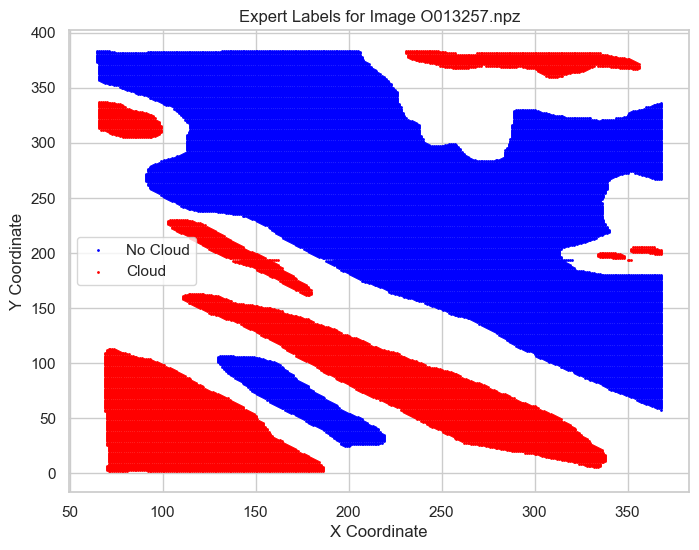

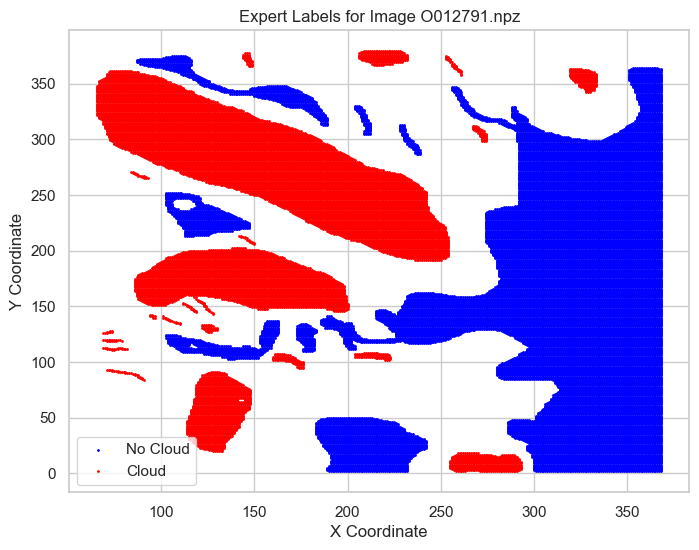

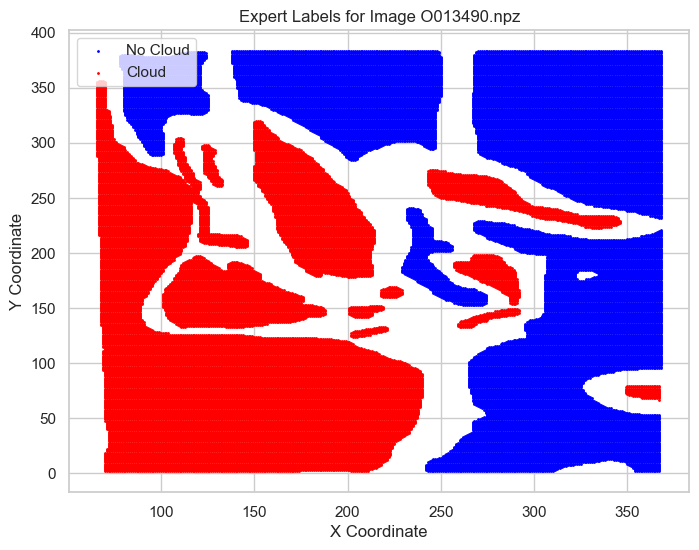

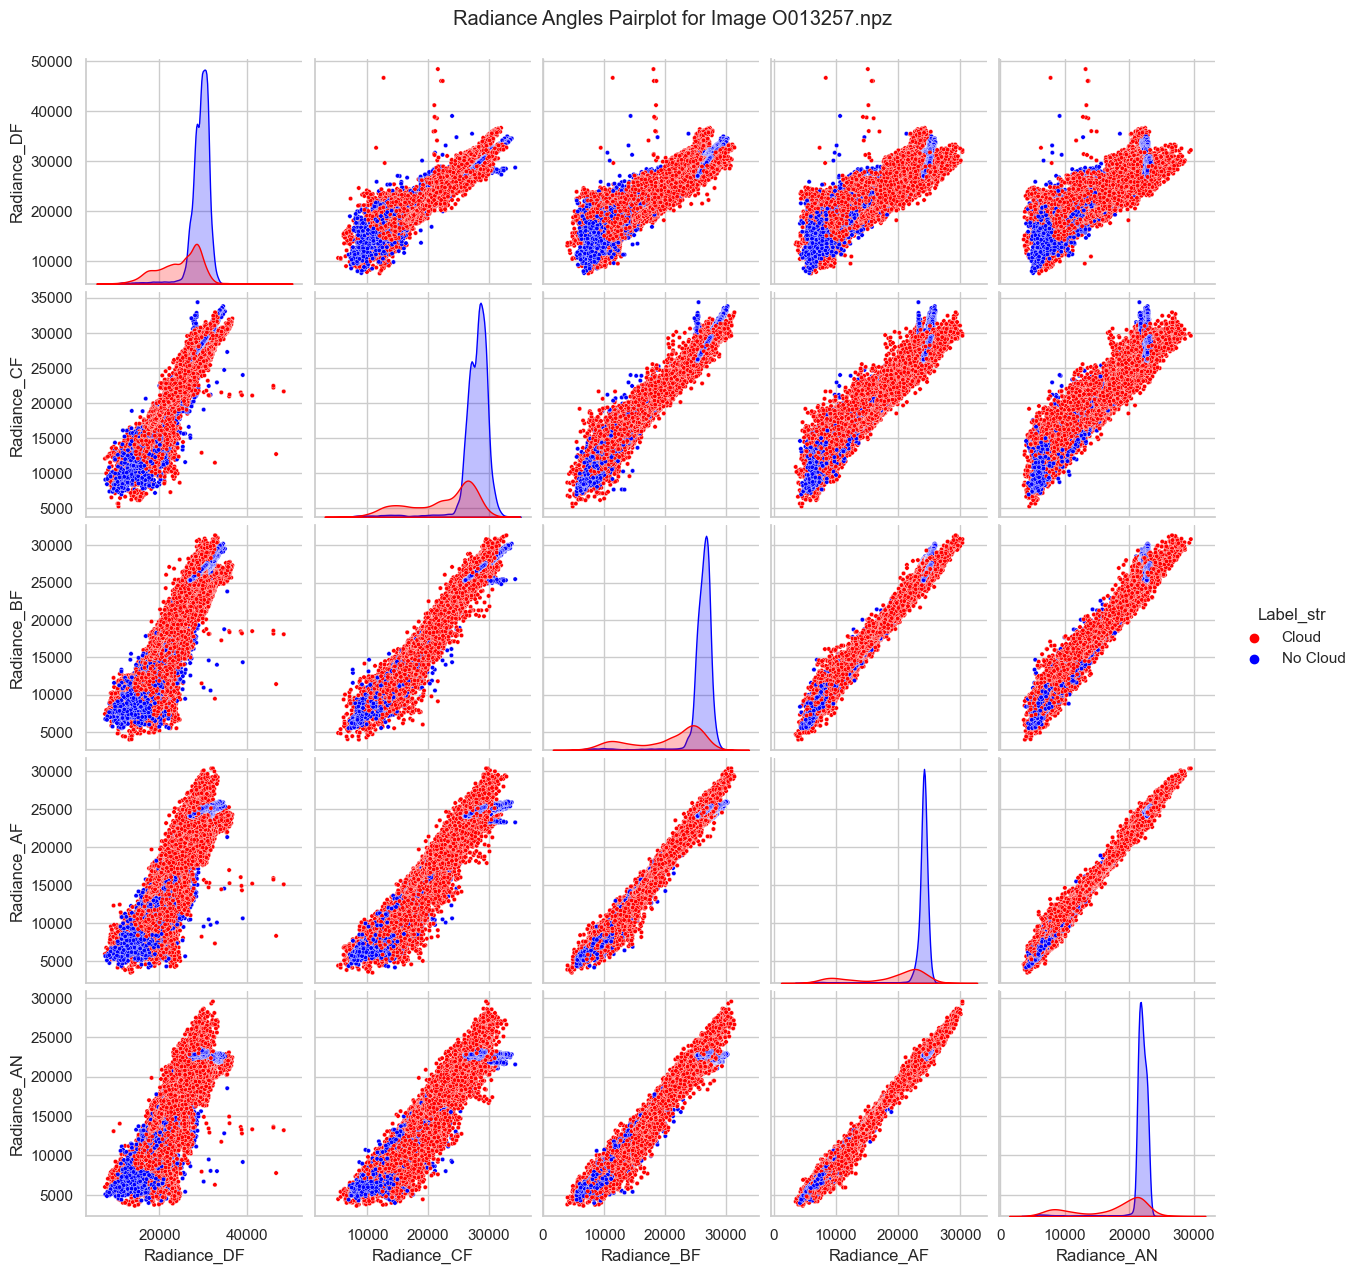

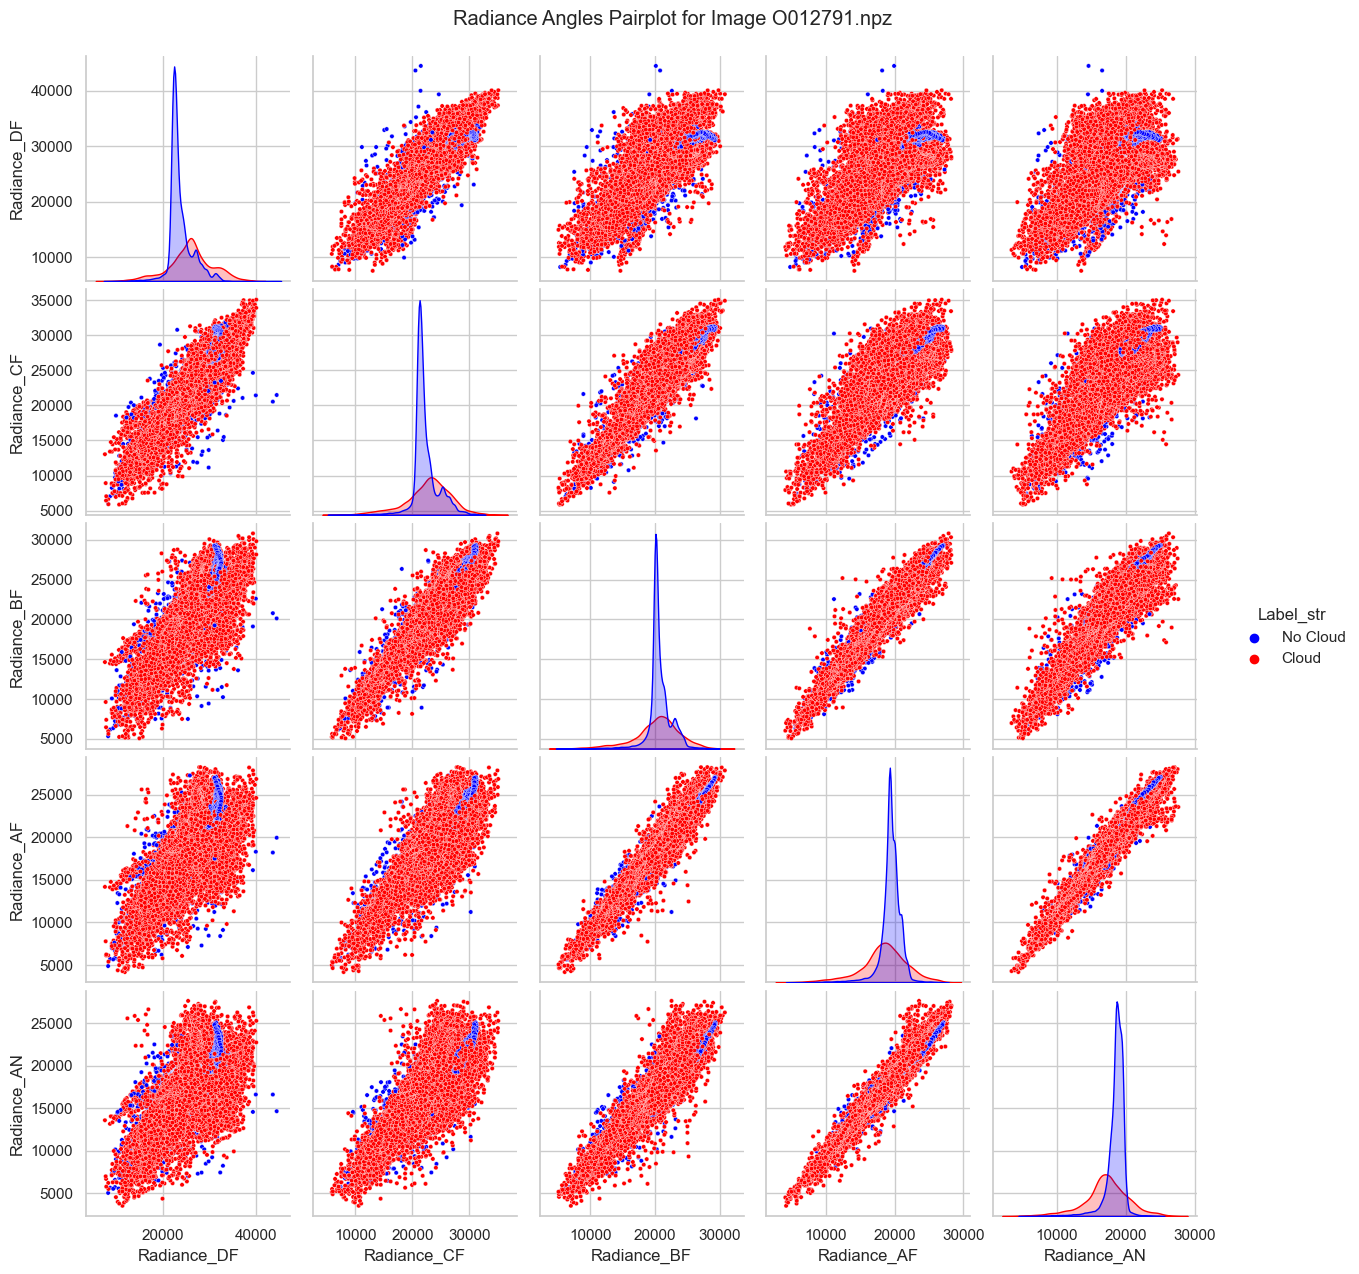

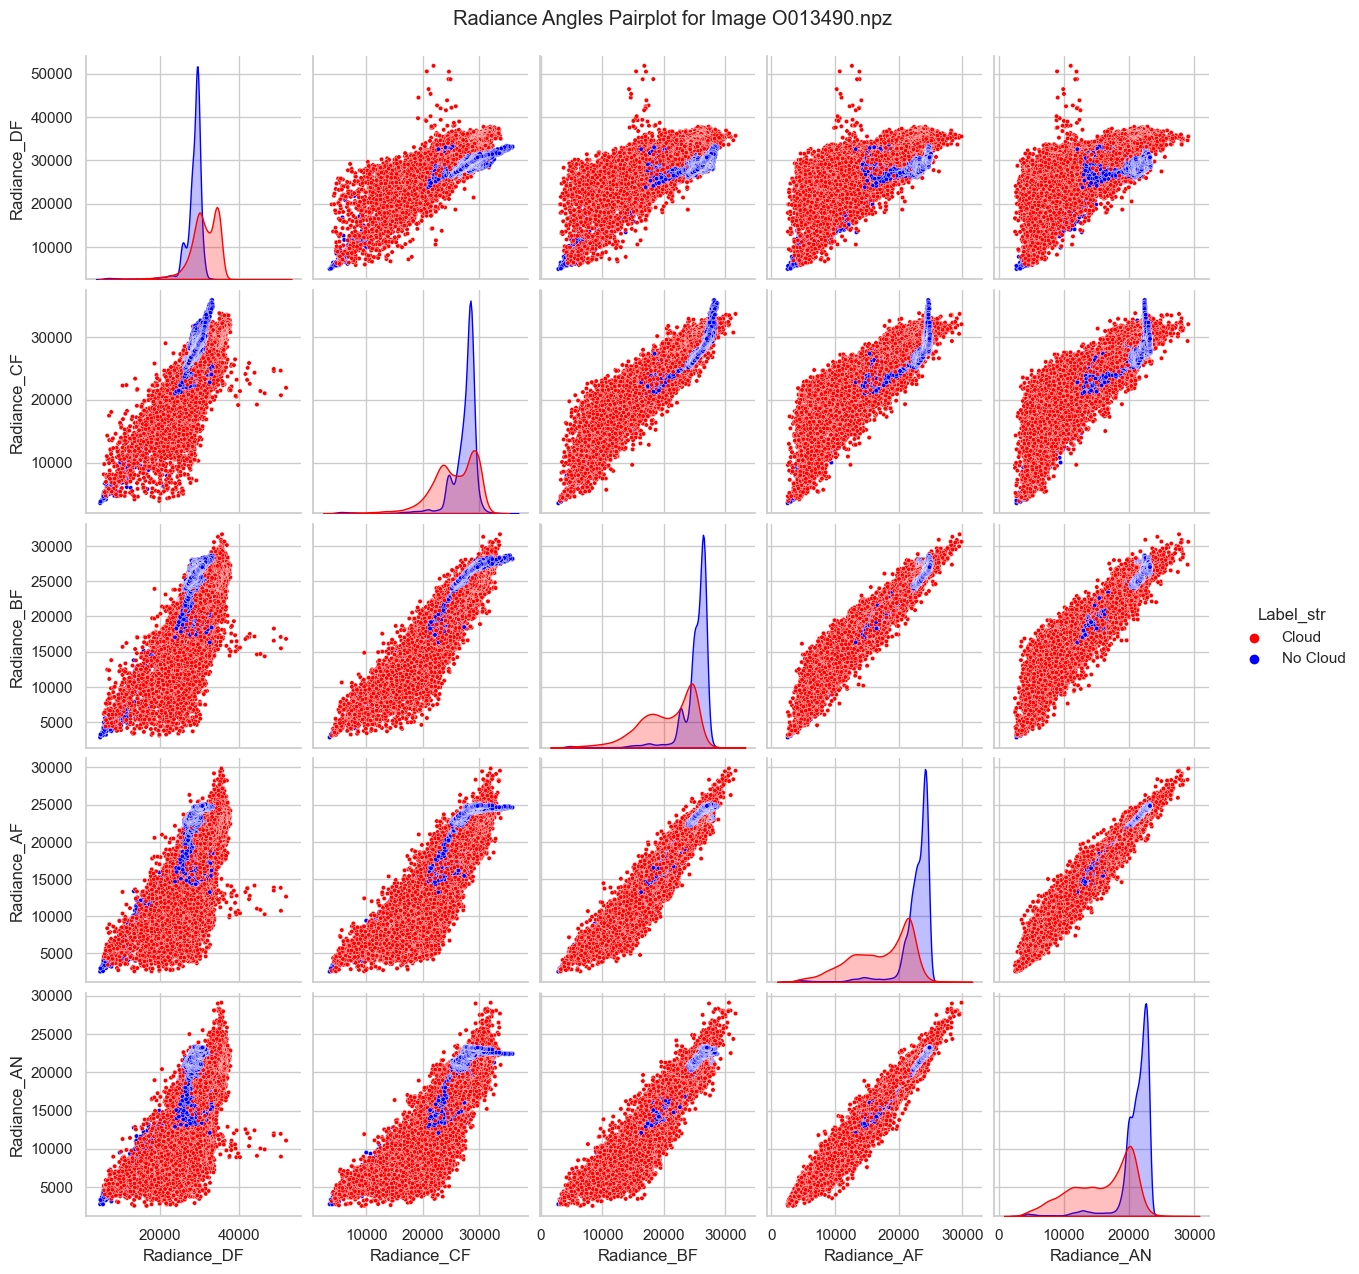

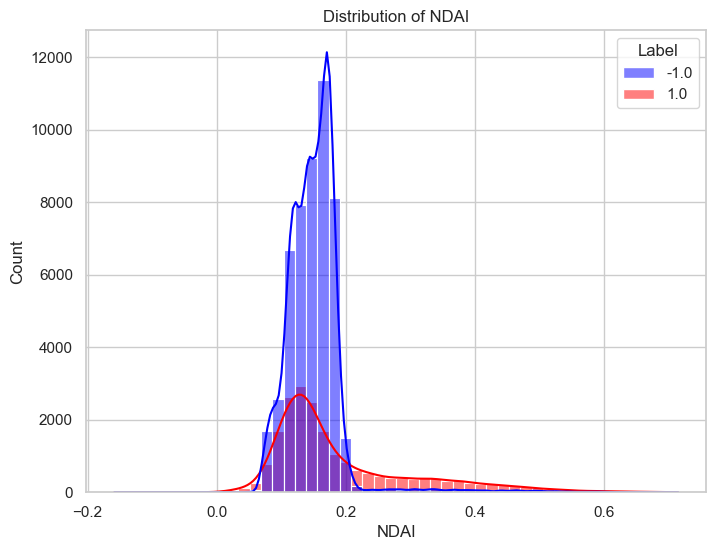

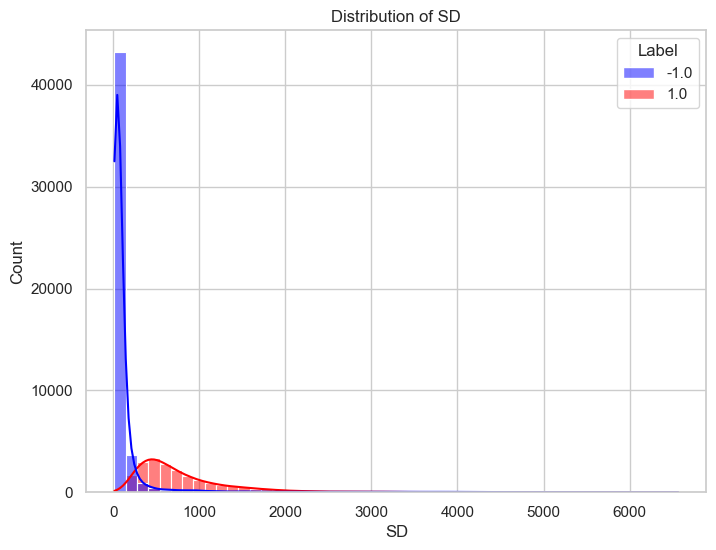

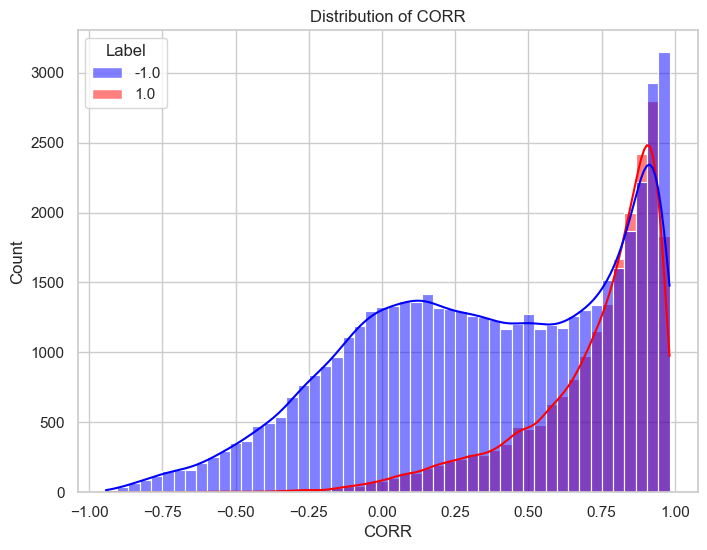

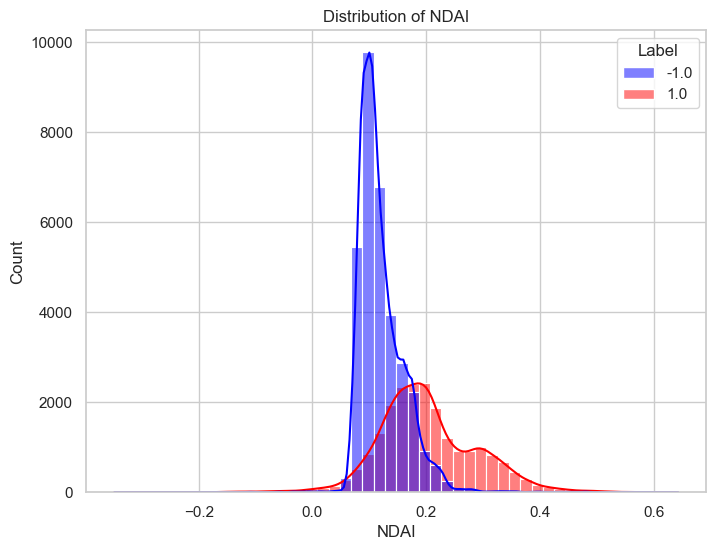

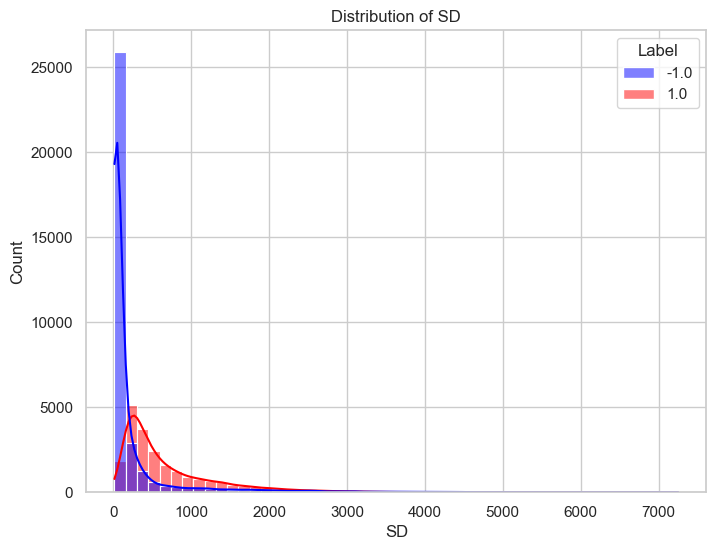

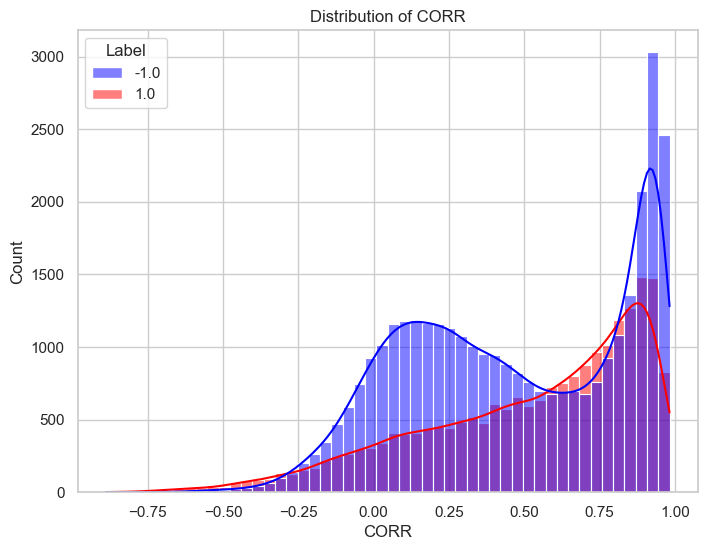

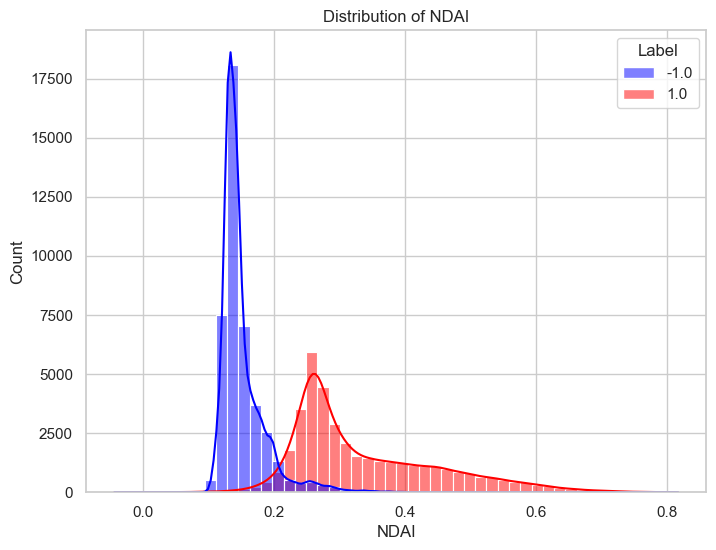

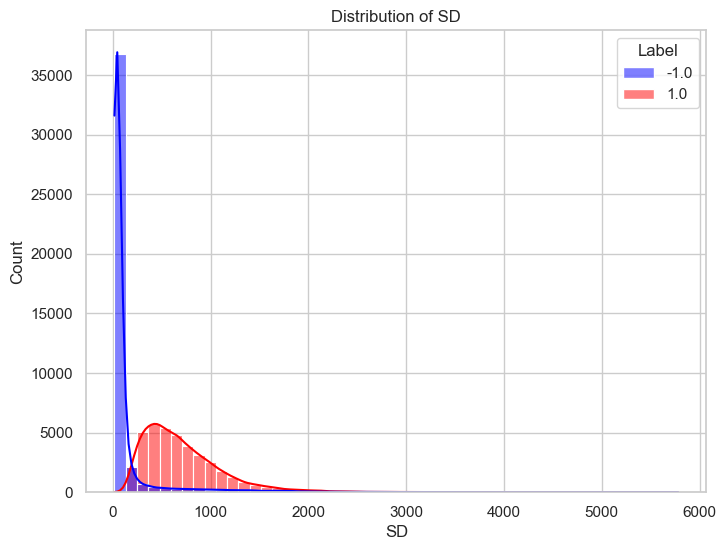

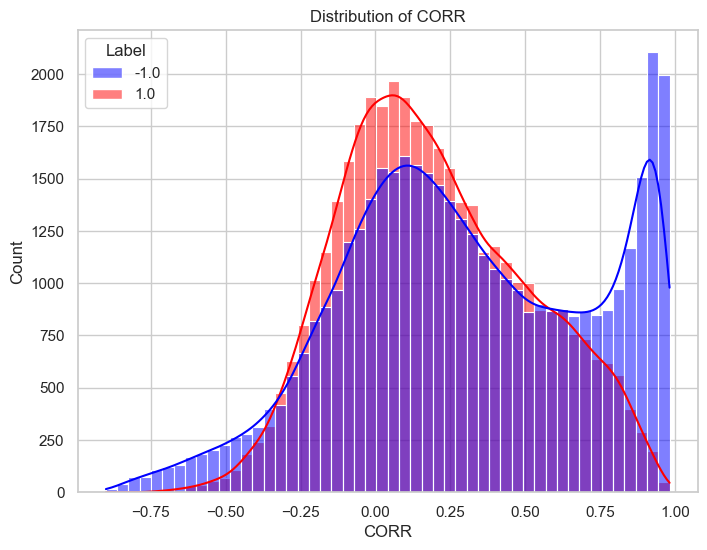

Feature-label correlations for O013257.npz: {'NDAI': 0.25242914489111357, 'SD': 0.5090591884232483, 'CORR': 0.3834714854568643}
Feature-label correlations for O012791.npz: {'NDAI': 0.531449286299134, 'SD': 0.3652106681571062, 'CORR': 0.06326419144069335}
Feature-label correlations for O013490.npz: {'NDAI': 0.7514083210234754, 'SD': 0.6004573998132082, 'CORR': -0.1381563596293206}
Size of training set: (125598, 11)
Size of validation set: (41041, 11)
Size of test set: (41042, 11)


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,6)

def load_npz(filename):
    data = np.load(filename)
    key = list(data.keys())[0]
    return data[key]

filenames = ["O013257.npz", "O012791.npz", "O013490.npz"]
columns = ["y", "x", "NDAI", "SD", "CORR", "Radiance_DF", "Radiance_CF", "Radiance_BF", "Radiance_AF", "Radiance_AN", "Label"]

dfs = []
for file in filenames:
    data = load_npz(file)
    df = pd.DataFrame(data, columns=columns)
    dfs.append(df)
    print(f"{file} loaded, shape: {df.shape}")

def plot_expert_labels(df, title):
    df_labeled = df[df["Label"] != 0]
    plt.figure(figsize=(8,6))
    colors = {-1: "blue", 1: "red"}
    for label, color in colors.items():
        subset = df_labeled[df_labeled["Label"] == label]
        plt.scatter(subset["x"], subset["y"], s=1, c=color, label="Cloud" if label==1 else "No Cloud")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(title)
    plt.legend()
    plt.show()

for i, df in enumerate(dfs):
    plot_expert_labels(df, f"Expert Labels for Image {filenames[i]}")

radiance_cols = ["Radiance_DF", "Radiance_CF", "Radiance_BF", "Radiance_AF", "Radiance_AN"]
feature_cols = ["NDAI", "SD", "CORR"]

def plot_radiance_pairplot(df, title):
    df_labeled = df[df["Label"] != 0]

    df_sample = df_labeled.copy()
    df_sample["Label_str"] = df_sample["Label"].apply(lambda x: "Cloud" if x == 1 else "No Cloud")
    sns.pairplot(df_sample, vars=radiance_cols, hue="Label_str", 
                 plot_kws={'s': 10}, palette={"Cloud": "red", "No Cloud": "blue"})
    plt.suptitle(title, y=1.02)
    plt.show()

def plot_feature_distribution(df, feature):
    df_labeled = df[df["Label"] != 0]
    plt.figure(figsize=(8,6))
    sns.histplot(data=df_labeled, x=feature, hue="Label", bins=50, 
                 palette={-1:"blue", 1:"red"}, kde=True)
    plt.title(f"Distribution of {feature}")
    plt.show()

for i, df in enumerate(dfs):
    plot_radiance_pairplot(df, f"Radiance Angles Pairplot for Image {filenames[i]}")

for i, df in enumerate(dfs):
    for feature in feature_cols:
        plot_feature_distribution(df, feature)

def compute_correlations(df, features):
    df_labeled = df[df["Label"] != 0]
    corr_dict = {}
    for feature in features:
        corr_val = df_labeled[feature].corr(df_labeled["Label"])
        corr_dict[feature] = corr_val
    return corr_dict

for i, df in enumerate(dfs):
    corrs = compute_correlations(df, feature_cols)
    print(f"Feature-label correlations for {filenames[i]}: {corrs}")

train_df = pd.concat([dfs[0][dfs[0]["Label"] != 0], dfs[1][dfs[1]["Label"] != 0]], ignore_index=True)
test_val_df = dfs[2][dfs[2]["Label"] != 0].copy()
test_val_df = test_val_df.sample(frac=1, random_state=42).reset_index(drop=True)
split_index = int(0.5 * len(test_val_df))
val_df = test_val_df.iloc[:split_index].copy()
test_df = test_val_df.iloc[split_index:].copy()

print("Size of training set:", train_df.shape)
print("Size of validation set:", val_df.shape)
print("Size of test set:", test_df.shape)

=== Mean values by class ===
            Radiance_DF   Radiance_CF   Radiance_BF   Radiance_AF  \
Label_str                                                           
Cloud      24539.197632  22373.694596  20344.621837  18583.599057   
No Cloud   29250.248715  27820.904954  25913.437973  23690.852007   

            Radiance_AN  
Label_str                
Cloud      17307.116487  
No Cloud   21668.976389  

=== Standard deviation by class ===
           Radiance_DF  Radiance_CF  Radiance_BF  Radiance_AF  Radiance_AN
Label_str                                                                 
Cloud      4837.472437  5453.881092  5788.107283  5764.709177  5484.248952
No Cloud   2425.634940  2645.408111  2565.875506  2363.079457  2139.952492

=== Median values by class ===
           Radiance_DF  Radiance_CF  Radiance_BF  Radiance_AF  Radiance_AN
Label_str                                                                 
Cloud          25682.5     24115.75    22369.875     20693.50     19407

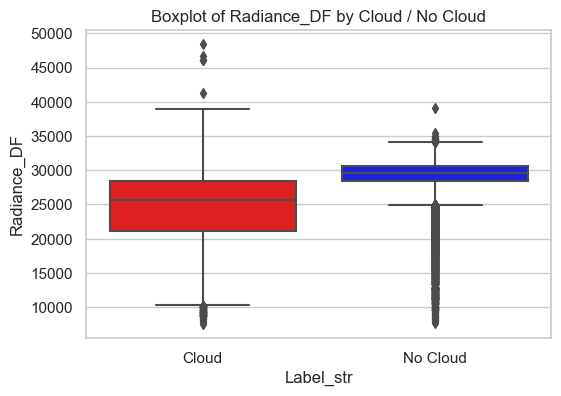

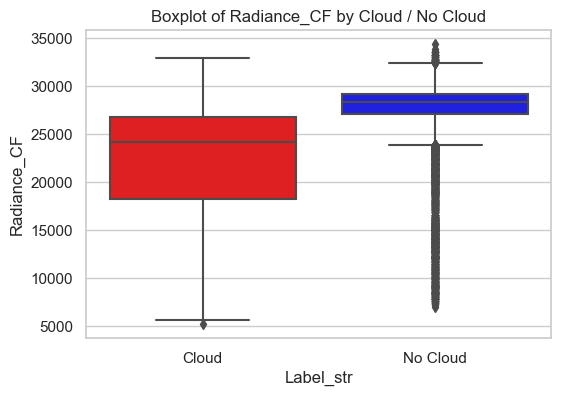

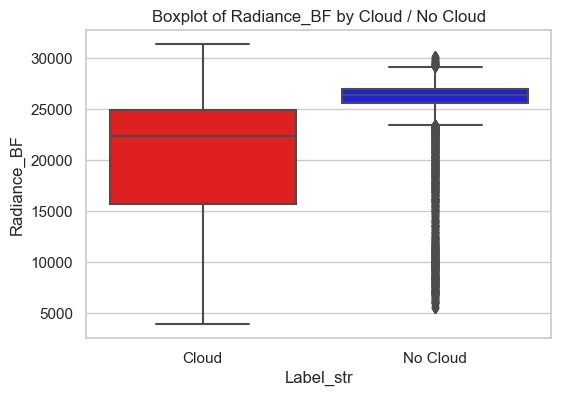

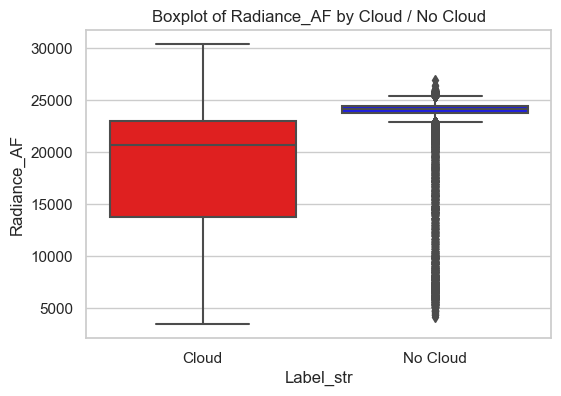

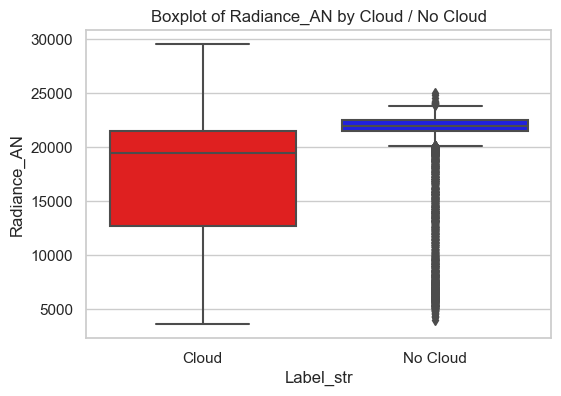

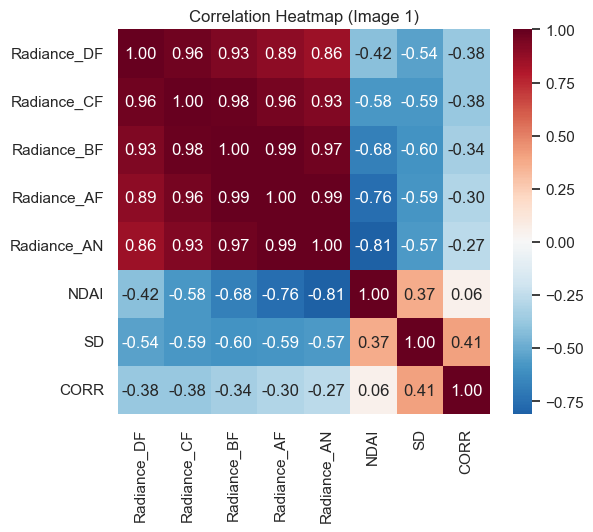

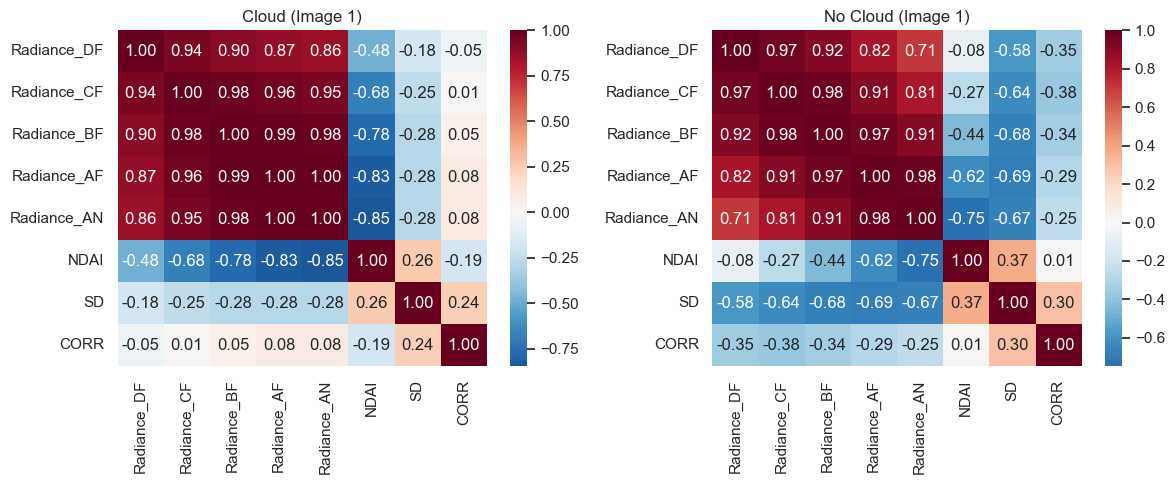

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (7,5)

def group_statistics(df, feature_cols, label_col="Label"):
    """
    Calculate grouped statistics (mean, std, median) for each feature, 
    comparing cloud vs. no-cloud pixels.
    """
    df_labeled = df[df[label_col] != 0].copy()
    df_labeled["Label_str"] = df_labeled[label_col].apply(lambda x: "Cloud" if x == 1 else "No Cloud")
    mean_vals = df_labeled.groupby("Label_str")[feature_cols].mean()
    std_vals = df_labeled.groupby("Label_str")[feature_cols].std()
    median_vals = df_labeled.groupby("Label_str")[feature_cols].median()
    
    print("=== Mean values by class ===")
    print(mean_vals)
    print("\n=== Standard deviation by class ===")
    print(std_vals)
    print("\n=== Median values by class ===")
    print(median_vals)


def boxplot_by_class(df, features, label_col="Label"):
    """
    Create boxplots for each feature, comparing cloud vs. no-cloud distributions.
    """
    df_labeled = df[df[label_col] != 0].copy()
    df_labeled["Label_str"] = df_labeled[label_col].apply(lambda x: "Cloud" if x == 1 else "No Cloud")
    
    for feature in features:
        plt.figure(figsize=(6,4))
        sns.boxplot(data=df_labeled, x="Label_str", y=feature,
                    palette={"Cloud":"red", "No Cloud":"blue"})
        plt.title(f"Boxplot of {feature} by Cloud / No Cloud")
        plt.show()

def correlation_heatmap(df, columns, title="Correlation Heatmap"):
    """
    Compute and plot a correlation heatmap for the given columns.
    """
    corr_matrix = df[columns].corr()
    plt.figure(figsize=(6,5))
    sns.heatmap(corr_matrix, annot=True, cmap="RdBu_r", center=0, fmt=".2f")
    plt.title(title)
    plt.show()


def correlation_by_class(df, columns, label_col="Label"):
    """
    Split the data into cloud vs. no-cloud, compute correlation matrices separately.
    Returns (corr_cloud, corr_nocloud).
    """
    df_labeled = df[df[label_col] != 0].copy()
    df_cloud = df_labeled[df_labeled[label_col] == 1]
    df_nocloud = df_labeled[df_labeled[label_col] == -1]
    
    corr_cloud = df_cloud[columns].corr()
    corr_nocloud = df_nocloud[columns].corr()
    return corr_cloud, corr_nocloud

def plot_two_heatmaps(corr1, corr2, title1="Cloud", title2="No Cloud"):
    """
    Plot two correlation heatmaps side by side for easy comparison.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    
    sns.heatmap(corr1, annot=True, cmap="RdBu_r", center=0, fmt=".2f", ax=axes[0])
    axes[0].set_title(title1)
    
    sns.heatmap(corr2, annot=True, cmap="RdBu_r", center=0, fmt=".2f", ax=axes[1])
    axes[1].set_title(title2)
    
    plt.tight_layout()
    plt.show()

radiance_cols = ["Radiance_DF", "Radiance_CF", "Radiance_BF", "Radiance_AF", "Radiance_AN"]
feature_cols = ["NDAI", "SD", "CORR"]
all_cols = radiance_cols + feature_cols

group_statistics(dfs[0], radiance_cols)

boxplot_by_class(dfs[0], radiance_cols)

correlation_heatmap(dfs[0][dfs[0]["Label"] != 0], all_cols, "Correlation Heatmap (Image 1)")

corr_cloud, corr_nocloud = correlation_by_class(dfs[0], all_cols)
plot_two_heatmaps(corr_cloud, corr_nocloud, "Cloud (Image 1)", "No Cloud (Image 1)")



In [3]:
from sklearn.preprocessing import StandardScaler
import os
import numpy as np
import pandas as pd


def loading(filename):
    '''
    Load the data from the given .npz file and return as a DataFrame.
    '''
    data = np.load(filename)
    key = list(data.keys())[0]
    columns = ["y", "x", "NDAI", "SD", "CORR", 
               "Radiance_DF", "Radiance_CF", "Radiance_BF", "Radiance_AF", "Radiance_AN", "Label"]
    df = pd.DataFrame(data[key], columns=columns)
    return df

def remove_outliers_3sig(df, column):
    ''''
    Remove rows with outliers which is defined as values outside 3 standard deviations from the mean.
    '''
    mean_val = df[column].mean()
    std_val = df[column].std()
    lower = mean_val - 3 * std_val
    upper = mean_val + 3 * std_val
    return df[(df[column] >= lower) & (df[column] <= upper)]

def cleaning_preprocessing(df):
    '''
    Preprocess the given DataFrame by removing missing values, duplicates, negative radiance values,
    unlabeled pixels, and outliers. Normalize selected features using StandardScaler.
    '''
    print("Initial data shape:", df.shape)
    print("Missing values per column:\n", df.isnull().sum())
    
    df_clean = df.dropna().copy()
    before = df_clean.shape[0]
    df_clean = df_clean.drop_duplicates()
    after = df_clean.shape[0]
    rad_col = ["Radiance_DF", "Radiance_CF", "Radiance_BF", "Radiance_AF", "Radiance_AN"]
    for col in rad_col:
        negative_num = (df_clean[col] < 0).sum()
        if negative_num > 0:
            print(f"Found {negative_num} negative values in {col}. Removing these rows.")
            df_clean = df_clean[df_clean[col] >= 0]

    df_clean = df_clean[df_clean["Label"] != 0]

    for feature in ["SD", "NDAI", "CORR"]:
        df_clean = remove_outliers_3sig(df_clean, feature)

    feature_cols = rad_col + ["NDAI", "SD", "CORR"]
    stdscaler = StandardScaler()
    df_clean[feature_cols] = stdscaler.fit_transform(df_clean[feature_cols])
    
    print("Final Shape:", df_clean.shape)
    return df_clean

filenames = ["O013257.npz", "O012791.npz", "O013490.npz"]
dataframes = {}

for file in filenames:
    df = loading(file)
    df_clean = cleaning_preprocessing(df)
    dataframes[file] = df_clean
combined_df = pd.concat(dataframes.values(), ignore_index=True)
print("Combined DataFrame shape:", combined_df.shape)


for file, df in dataframes.items():
    base_name = os.path.basename(file) 
    output_name = base_name.replace('.npz', '_cleaned.npz')
    np.savez_compressed(output_name, data=df.to_numpy())
    print(f"Saved cleaned data to {output_name}")


Initial data shape: (115000, 11)
Missing values per column:
 y              0
x              0
NDAI           0
SD             0
CORR           0
Radiance_DF    0
Radiance_CF    0
Radiance_BF    0
Radiance_AF    0
Radiance_AN    0
Label          0
dtype: int64
Final Shape: (67106, 11)
Initial data shape: (114973, 11)
Missing values per column:
 y              0
x              0
NDAI           0
SD             0
CORR           0
Radiance_DF    0
Radiance_CF    0
Radiance_BF    0
Radiance_AF    0
Radiance_AN    0
Label          0
dtype: int64
Final Shape: (52571, 11)
Initial data shape: (115032, 11)
Missing values per column:
 y              0
x              0
NDAI           0
SD             0
CORR           0
Radiance_DF    0
Radiance_CF    0
Radiance_BF    0
Radiance_AF    0
Radiance_AN    0
Label          0
dtype: int64
Final Shape: (79880, 11)
Combined DataFrame shape: (199557, 11)
Saved cleaned data to O013257_cleaned.npz
Saved cleaned data to O012791_cleaned.npz
Saved cleaned data 

In [4]:
import glob
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def loading(filename):
    '''
    Load the data from the given .npz file and return as a DataFrame.
    '''
    data = np.load(filename)
    key = list(data.keys())[0]
    columns = ["y", "x", "NDAI", "SD", "CORR", 
               "Radiance_DF", "Radiance_CF", "Radiance_BF", "Radiance_AF", "Radiance_AN"]
    df = pd.DataFrame(data[key], columns=columns)
    return df

def remove_outliers_3sig(df, column):
    ''''
    Remove rows with outliers which is defined as values outside 3 standard deviations from the mean.
    '''
    mean_val = df[column].mean()
    std_val = df[column].std()
    lower = mean_val - 3 * std_val
    upper = mean_val + 3 * std_val
    return df[(df[column] >= lower) & (df[column] <= upper)]

def cleaning_preprocessing(df):
    '''
    Preprocess the given DataFrame by removing missing values, duplicates, negative radiance values,
    unlabeled pixels, and outliers. Normalize selected features using StandardScaler.
    '''
    print("Initial data shape:", df.shape)
    print("Missing values per column:\n", df.isnull().sum())
    
    df_clean = df.dropna().copy()
    before = df_clean.shape[0]
    df_clean = df_clean.drop_duplicates()
    after = df_clean.shape[0]
    rad_col = ["Radiance_DF", "Radiance_CF", "Radiance_BF", "Radiance_AF", "Radiance_AN"]
    for col in rad_col:
        negative_num = (df_clean[col] < 0).sum()
        if negative_num > 0:
            print(f"Found {negative_num} negative values in {col}. Removing these rows.")
            df_clean = df_clean[df_clean[col] >= 0]


    for feature in ["SD", "NDAI", "CORR"]:
        df_clean = remove_outliers_3sig(df_clean, feature)

    feature_cols = rad_col + ["NDAI", "SD", "CORR"]
    stdscaler = StandardScaler()
    df_clean[feature_cols] = stdscaler.fit_transform(df_clean[feature_cols])
    
    print("Final Shape:", df_clean.shape)
    return df_clean

input_dir = "C:\\Users\\lenovo\\Desktop\\stats214\\lab2wzh\\image_data"

output_dir = "C:\\Users\\lenovo\\Desktop\\stats214\\lab2wzh\\new_image"


filenames = glob.glob(os.path.join(input_dir, "*.npz"))
dataframes = {}

for file in filenames:
    print(f"Processing {file} ...")
    df = loading(file)
    df_clean = cleaning_preprocessing(df)
    dataframes[file] = df_clean

for file, df in dataframes.items():
    base_name = os.path.basename(file)
    output_name = base_name.replace(".npz", "_cleaned.npz")
    output_path = os.path.join(output_dir, output_name)
    np.savez_compressed(output_path, data=df.to_numpy())
    print(f"Saved cleaned data to {output_path}")

Processing C:\Users\lenovo\Desktop\stats214\lab2wzh\image_data\O002539.npz ...
Initial data shape: (115378, 10)
Missing values per column:
 y              0
x              0
NDAI           0
SD             0
CORR           0
Radiance_DF    0
Radiance_CF    0
Radiance_BF    0
Radiance_AF    0
Radiance_AN    0
dtype: int64
Final Shape: (111359, 10)
Processing C:\Users\lenovo\Desktop\stats214\lab2wzh\image_data\O002772.npz ...
Initial data shape: (115668, 10)
Missing values per column:
 y              0
x              0
NDAI           0
SD             0
CORR           0
Radiance_DF    0
Radiance_CF    0
Radiance_BF    0
Radiance_AF    0
Radiance_AN    0
dtype: int64
Final Shape: (109035, 10)
Processing C:\Users\lenovo\Desktop\stats214\lab2wzh\image_data\O003005.npz ...
Initial data shape: (115923, 10)
Missing values per column:
 y              0
x              0
NDAI           0
SD             0
CORR           0
Radiance_DF    0
Radiance_CF    0
Radiance_BF    0
Radiance_AF    0
Radiance_

Correlation between NDAI and Label: 0.511
Correlation between SD and Label: 0.631
Correlation between CORR and Label: 0.077
Correlation between Radiance_DF and Label: 0.072
Correlation between Radiance_CF and Label: -0.249
Correlation between Radiance_BF and Label: -0.407
Correlation between Radiance_AF and Label: -0.459
Correlation between Radiance_AN and Label: -0.461


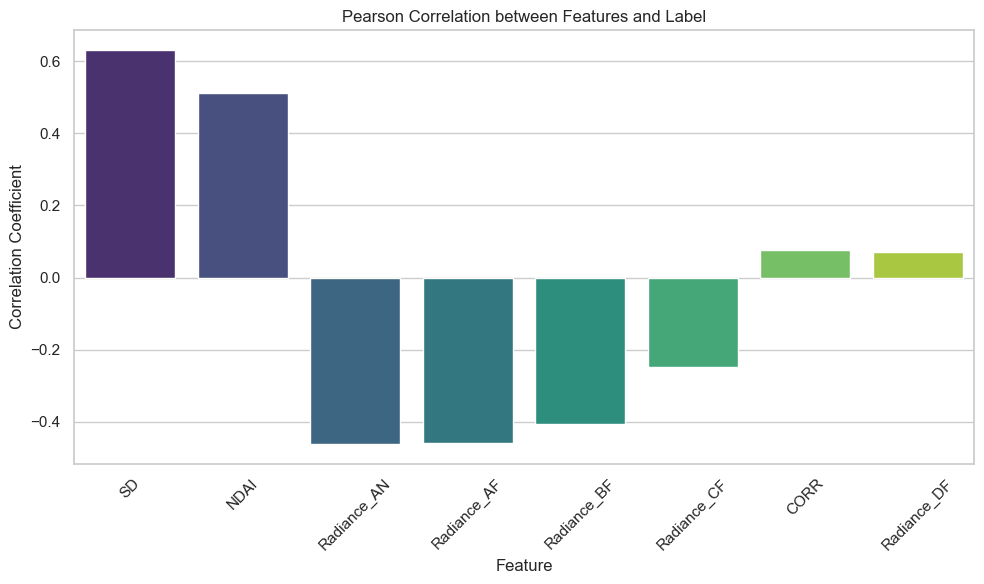

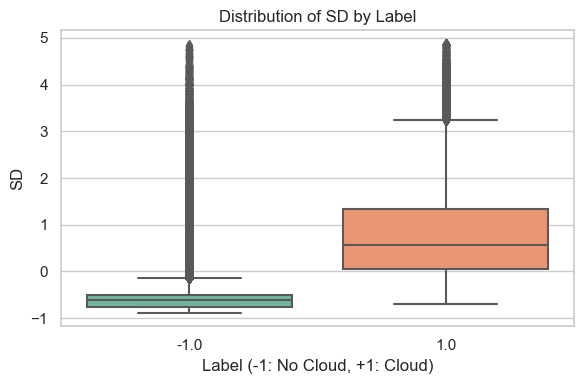

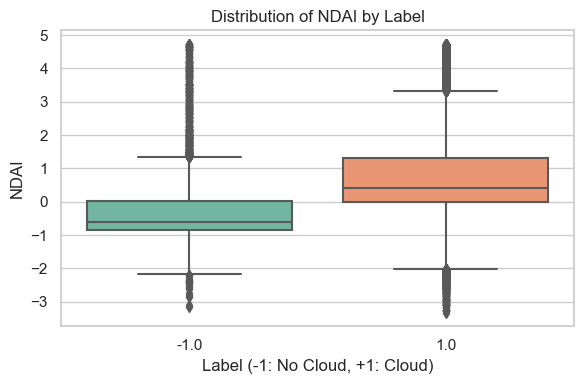

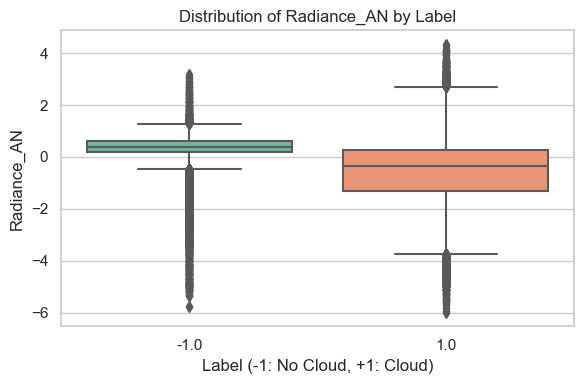

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

features = ["NDAI", "SD", "CORR", 
            "Radiance_DF", "Radiance_CF", "Radiance_BF", "Radiance_AF", "Radiance_AN"]

# Compute Pearson correlation between each feature and the label
correlations = {}
for feature in features:
    corr_val = combined_df[feature].corr(combined_df["Label"])
    correlations[feature] = corr_val
    print(f"Correlation between {feature} and Label: {corr_val:.3f}")

corr_df = pd.DataFrame.from_dict(correlations, orient="index", columns=["Correlation"])
# Create a absolute correlation column for sorting
corr_df["abs_corr"] = corr_df["Correlation"].abs()
corr_df = corr_df.sort_values(by="abs_corr", ascending=False)

# Plot the correlation values
plt.figure(figsize=(10,6))
sns.barplot(x=corr_df.index, y=corr_df["Correlation"], palette="viridis")
plt.xticks(rotation=45)
plt.title("Pearson Correlation between Features and Label")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

top_features = corr_df.index[:3].tolist()  
for feature in top_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Label", y=feature, data=combined_df, palette="Set2")
    plt.title(f"Distribution of {feature} by Label")
    plt.xlabel("Label (-1: No Cloud, +1: Cloud)")
    plt.tight_layout()
    plt.show()

In [6]:
from sklearn.feature_selection import f_classif

X = combined_df[top_features]
y = combined_df["Label"]

f_scores, p_values = f_classif(X, y)

f_score_df = pd.DataFrame({"Feature": top_features, "F-score": f_scores, "p-value": p_values})
f_score_df = f_score_df.sort_values(by="F-score", ascending=False)

print(f_score_df)

combined_df.groupby("Label")[["SD", "NDAI", "Radiance_AN"]].agg(["mean", "std"])



       Feature        F-score  p-value
0           SD  131814.402494      0.0
1         NDAI   70614.646632      0.0
2  Radiance_AN   53894.958312      0.0


SD                NDAI           Radiance_AN          
           mean       std      mean       std        mean       std
Label                                                              
-1.0  -0.490167  0.600334 -0.397327  0.621540    0.358383  0.530313
 1.0   0.811533  1.001290  0.657825  1.149764   -0.593347  1.274884

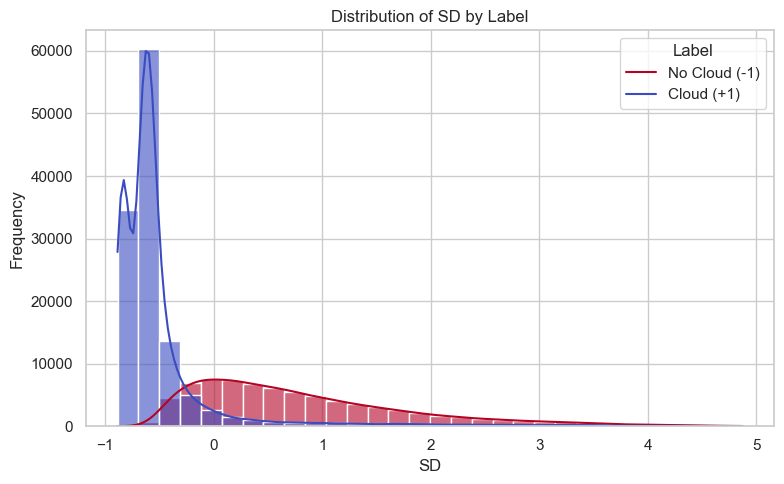

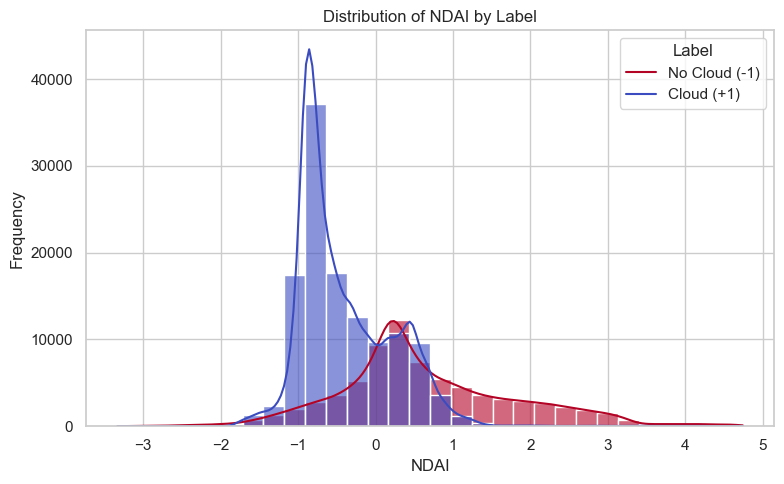

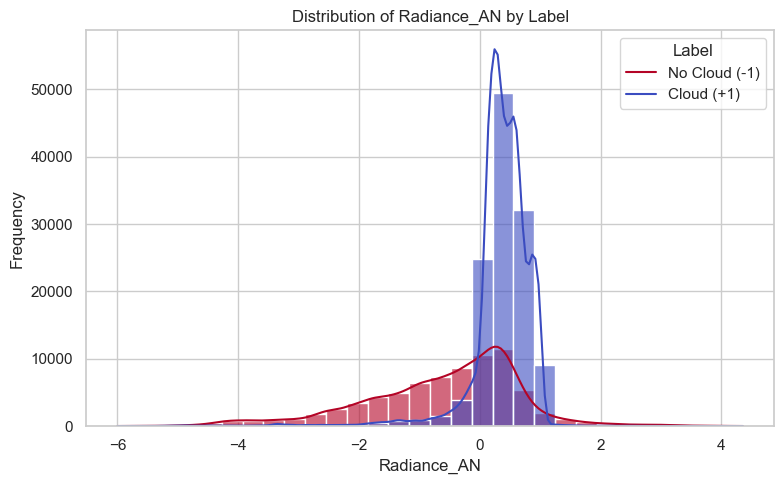

In [7]:
for feature in top_features:
    plt.figure(figsize=(8,5))
    sns.histplot(data=combined_df, x=feature, hue="Label", kde=True, bins=30, palette="coolwarm", alpha=0.6)
    plt.title(f"Distribution of {feature} by Label")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.legend(title="Label", labels=["No Cloud (-1)", "Cloud (+1)"])
    plt.tight_layout()
    plt.show()


Random Forest Feature Importances:
       Feature  Importance
1           SD    0.394976
7  Radiance_AN    0.125953
6  Radiance_AF    0.104357
0         NDAI    0.091838
3  Radiance_DF    0.088156
2         CORR    0.087960
5  Radiance_BF    0.060138
4  Radiance_CF    0.046622


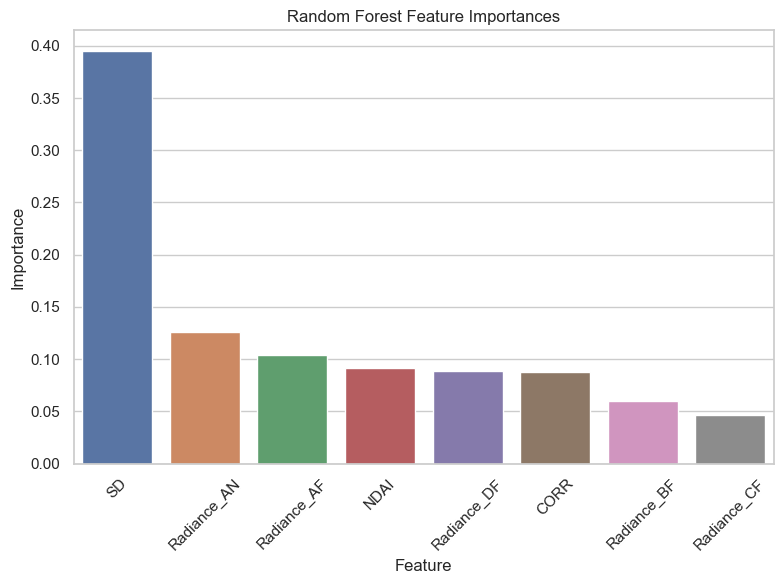

In [8]:
from sklearn.ensemble import RandomForestClassifier

X = combined_df[features]
y = combined_df["Label"]

# Another way to compute feature importances using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state= 918)
rf.fit(X, y)
rf_importances = rf.feature_importances_
rf_df = pd.DataFrame({'Feature': features, 'Importance': rf_importances})
rf_df = rf_df.sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importances:")
print(rf_df)

plt.figure(figsize=(8,6))
sns.barplot(x="Feature", y="Importance", data=rf_df)
plt.title("Random Forest Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
done reshaping images
working on image 0
Combined augmented DataFrame shape: (199557, 13)
     y      x      NDAI        SD      CORR  Radiance_DF  Radiance_CF  \
0  2.0  190.0  0.463230  4.142132  0.295398     0.891307     0.539628   
1  2.0  191.0 -1.916252  3.879452  0.634386    -0.922766    -0.175734   
2  2.0  199.0 -0.076644  3.593819  0.120849     0.652988     0.604795   
3  2.0  200.0 -2.418837  3.502453 -0.453395    -0.892129     0.117864   
4  2.0  201.0 -2.128905  3.862626 -0.540081    -0.436670    -1.497182   

   Radiance_BF  Radiance_AF  Radiance_AN  Label  patch_range  patch_entropy  
0     0.910783     1.072077     0.546184   -1.0     8.008906       0.461251  
1     0.492761     0.508566     0.960594   -1.0     8.041062       0.625510  
2     2.082042     0.965399     0.911623   -1.0    10.601785       0.907728  
3     2.704186   

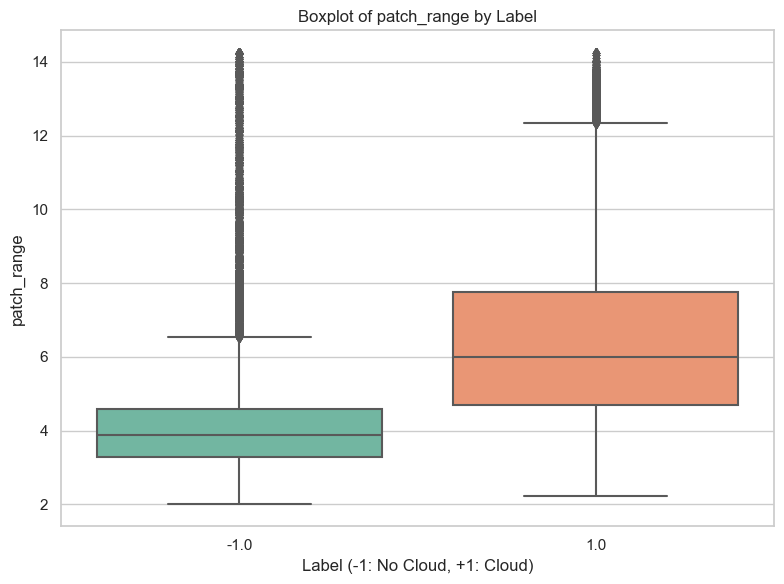

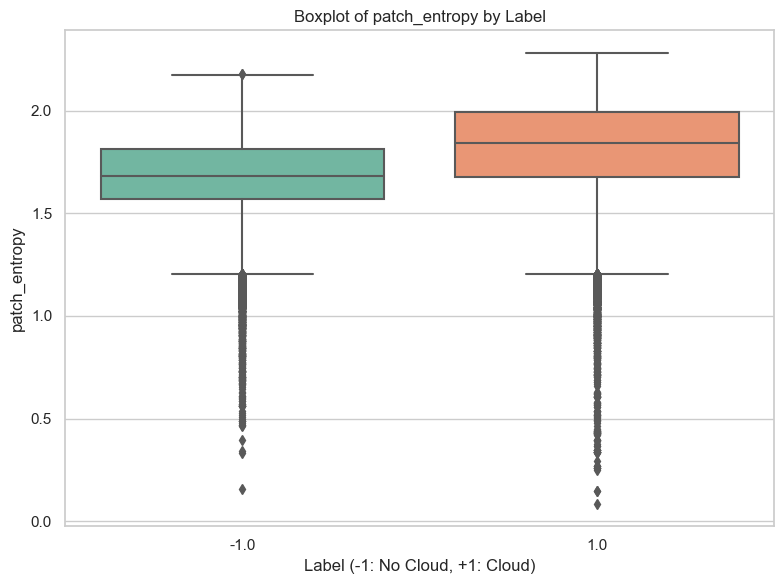

In [9]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from scipy.stats import pearsonr

plt.rcParams["figure.figsize"] = (8,6)

def make_data(patch_size=9):
    """
    Load the image data from .npz files and create patches.
    For expert-labeled images (with 11 columns), the label is preserved.
    Returns:
        images_long: A list of numpy arrays of the original images (with label if present).
        patches: A list of lists of patches for each image.
    """

    # We only use the data with labels
    filepaths = glob.glob("C:\\Users\\lenovo\\Desktop\\stats214\\lab2wzh\\testdatalab2\\*.npz") 
    images_long = []
    for fp in filepaths:
        npz_data = np.load(fp)
        key = list(npz_data.files)[0]
        data = npz_data[key]
        # DO NOT remove labels
        images_long.append(data)

    all_y = np.concatenate([img[:, 0] for img in images_long]).astype(int)
    all_x = np.concatenate([img[:, 1] for img in images_long]).astype(int)
    global_miny, global_maxy = all_y.min(), all_y.max()
    global_minx, global_maxx = all_x.min(), all_x.max()
    height = int(global_maxy - global_miny + 1)
    width = int(global_maxx - global_minx + 1)

    has_label = (images_long[0].shape[1] == 11)
    nchannels = images_long[0].shape[1] - 3 if has_label else images_long[0].shape[1] - 2

    images = []
    for img in images_long:
        y = img[:, 0].astype(int)
        x = img[:, 1].astype(int)
        y_rel = y - global_miny
        x_rel = x - global_minx
        image = np.zeros((nchannels, height, width))
        valid_mask = (y_rel >= 0) & (y_rel < height) & (x_rel >= 0) & (x_rel < width)
        y_valid = y_rel[valid_mask]
        x_valid = x_rel[valid_mask]
        img_valid = img[valid_mask]
        for c in range(nchannels):
            image[c, y_valid, x_valid] = img_valid[:, c + 2]
        images.append(image)
    print('done reshaping images')

    images = np.array(images)
    pad_len = patch_size // 2
    means = np.mean(images, axis=(0, 2, 3))[:, None, None]
    stds = np.std(images, axis=(0, 2, 3))[:, None, None]
    images = (images - means) / stds

    patches = []
    for i in range(len(images_long)):
        if i % 10 == 0:
            print(f'working on image {i}')
        patches_img = []
        img_mirror = np.pad(
            images[i],
            ((0, 0), (pad_len, pad_len), (pad_len, pad_len)),
            mode="reflect",
        )
        ys = images_long[i][:, 0].astype(int)
        xs = images_long[i][:, 1].astype(int)
        for y, x in zip(ys, xs):
            y_idx = int(y - global_miny + pad_len)
            x_idx = int(x - global_minx + pad_len)
            patch = img_mirror[
                :,
                y_idx - pad_len : y_idx + pad_len + 1,
                x_idx - pad_len : x_idx + pad_len + 1,
            ]
            patches_img.append(patch.astype(np.float32))
        patches.append(patches_img)

    return images_long, patches

def compute_patch_entropy(patch, bins=10):
    flat_patch = patch.flatten()
    hist, _ = np.histogram(flat_patch, bins=bins, density=True)
    hist = hist + 1e-8  # avoid log(0)
    return entropy(hist)

def extract_range_entropy_features(patches):
    """
    For each patch, compute:
      - Range: max value - min value (across all channels in the patch).
      - Entropy: entropy of the patch's pixel distribution.
    Returns:
        feature_list: A list of numpy arrays (one per image) with shape (num_pixels, 2).
    """
    # Entropy is not good
    feature_list = []
    for patches_img in patches:
        ranges = []
        entropies = []
        for patch in patches_img:
            r = np.max(patch) - np.min(patch)
            e = compute_patch_entropy(patch, bins=10)
            ranges.append(r)
            entropies.append(e)
        feature_array = np.column_stack((ranges, entropies))
        feature_list.append(feature_array)
    return feature_list

images_long, patches = make_data(patch_size=9)
new_features = extract_range_entropy_features(patches)

augmented_dfs = []
for i, data in enumerate(images_long):
    df = combined_df
    df = pd.DataFrame(data, columns=["y", "x", "NDAI", "SD", "CORR",
                                       "Radiance_DF", "Radiance_CF", "Radiance_BF", "Radiance_AF", "Radiance_AN", "Label"])
    df["patch_range"] = new_features[i][:, 0]
    df["patch_entropy"] = new_features[i][:, 1]
    augmented_dfs.append(df)

combined_augmented_df = pd.concat(augmented_dfs, ignore_index=True)
print("Combined augmented DataFrame shape:", combined_augmented_df.shape)
print(combined_augmented_df.head())

corr_range = combined_augmented_df["patch_range"].corr(combined_augmented_df["Label"])
corr_entropy = combined_augmented_df["patch_entropy"].corr(combined_augmented_df["Label"])
print(f"Pearson correlation (patch_range vs Label): {corr_range:.3f}")
print(f"Pearson correlation (patch_entropy vs Label): {corr_entropy:.3f}")


plt.figure(figsize=(8,6))
sns.boxplot(x="Label", y="patch_range", data=combined_augmented_df, palette="Set2")
plt.title("Boxplot of patch_range by Label")
plt.xlabel("Label (-1: No Cloud, +1: Cloud)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(x="Label", y="patch_entropy", data=combined_augmented_df, palette="Set2")
plt.title("Boxplot of patch_entropy by Label")
plt.xlabel("Label (-1: No Cloud, +1: Cloud)")
plt.tight_layout()
plt.show()


done reshaping images
working on image 0
Combined augmented DataFrame shape: (199557, 13)
     y      x      NDAI        SD      CORR  Radiance_DF  Radiance_CF  \
0  2.0  190.0  0.463230  4.142132  0.295398     0.891307     0.539628   
1  2.0  191.0 -1.916252  3.879452  0.634386    -0.922766    -0.175734   
2  2.0  199.0 -0.076644  3.593819  0.120849     0.652988     0.604795   
3  2.0  200.0 -2.418837  3.502453 -0.453395    -0.892129     0.117864   
4  2.0  201.0 -2.128905  3.862626 -0.540081    -0.436670    -1.497182   

   Radiance_BF  Radiance_AF  Radiance_AN  Label  pca_feature  grad_mean  
0     0.910783     1.072077     0.546184   -1.0     0.640682   1.814013  
1     0.492761     0.508566     0.960594   -1.0     0.602172   2.721935  
2     2.082042     0.965399     0.911623   -1.0     0.534968   4.674143  
3     2.704186     2.033825     1.632731   -1.0     0.524147   4.186285  
4     2.325990     2.180590     1.993687   -1.0     0.436756   4.239791  
Pearson correlation (pca_fe

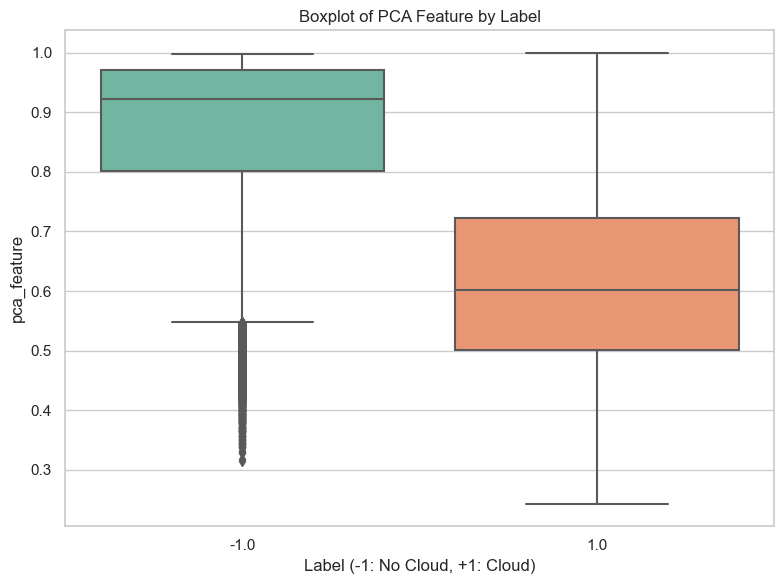

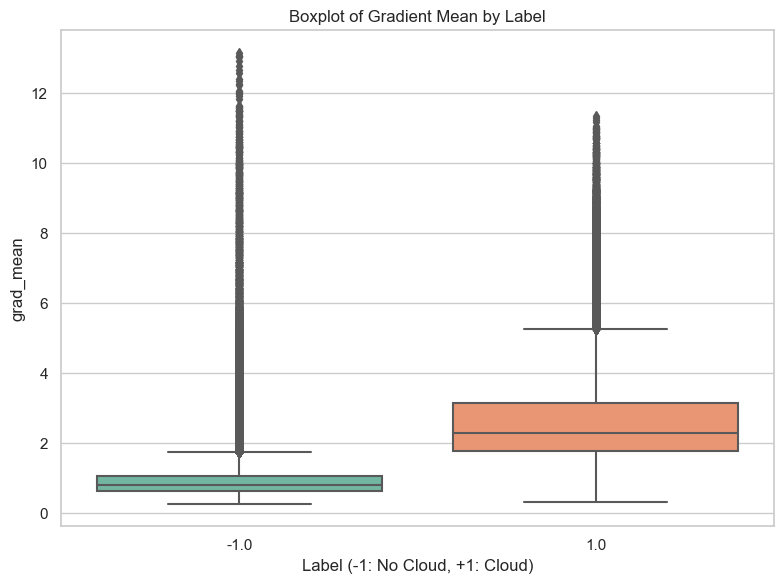

In [10]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage as ndimage
from sklearn.decomposition import PCA


# Using PCA to compute explained variance ratio of a patch
def compute_patch_pca_feature(patch):
    channels, _ , _ = patch.shape
    patch_reshaped = patch.reshape(channels, -1).T  
    pca = PCA(n_components=1)
    pca.fit(patch_reshaped)
    return pca.explained_variance_ratio_[0]

def compute_patch_grad_mean(patch):
    channels = patch.shape[0]
    grad_means = []
    for c in range(channels):
        gx = ndimage.sobel(patch[c], axis=0)
        gy = ndimage.sobel(patch[c], axis=1)
        grad = np.hypot(gx, gy)
        grad_means.append(np.mean(grad))
    return np.mean(grad_means)

images_long, patches = make_data(patch_size=9)

pca_features_list = [] 
grad_features_list = [] 
for patches_img in patches:
    pca_feats = []
    grad_feats = []
    for patch in patches_img:
        pca_feat = compute_patch_pca_feature(patch)
        grad_feat = compute_patch_grad_mean(patch)
        pca_feats.append(pca_feat)
        grad_feats.append(grad_feat)
    pca_features_list.append(np.array(pca_feats))
    grad_features_list.append(np.array(grad_feats))


augmented_dfs = []
for i, data in enumerate(images_long):
    df = pd.DataFrame(data, columns=["y", "x", "NDAI", "SD", "CORR",
                                       "Radiance_DF", "Radiance_CF", "Radiance_BF", "Radiance_AF", "Radiance_AN", "Label"])
    df["pca_feature"] = pca_features_list[i]
    df["grad_mean"] = grad_features_list[i]
    augmented_dfs.append(df)

combined_augmented_df = pd.concat(augmented_dfs, ignore_index=True)
print("Combined augmented DataFrame shape:", combined_augmented_df.shape)
print(combined_augmented_df.head())

corr_pca = combined_augmented_df["pca_feature"].corr(combined_augmented_df["Label"])
corr_grad = combined_augmented_df["grad_mean"].corr(combined_augmented_df["Label"])
print(f"Pearson correlation (pca_feature vs Label): {corr_pca:.3f}")
print(f"Pearson correlation (grad_mean vs Label): {corr_grad:.3f}")

plt.figure(figsize=(8,6))
sns.boxplot(x="Label", y="pca_feature", data=combined_augmented_df, palette="Set2")
plt.title("Boxplot of PCA Feature by Label")
plt.xlabel("Label (-1: No Cloud, +1: Cloud)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(x="Label", y="grad_mean", data=combined_augmented_df, palette="Set2")
plt.title("Boxplot of Gradient Mean by Label")
plt.xlabel("Label (-1: No Cloud, +1: Cloud)")
plt.tight_layout()
plt.show()